In [ ]:
!pip install tensorflow_decision_forests

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.fft import fft

import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from xgboost import XGBRegressor
import ydf

In [ ]:
uploaded = files.upload()

Saving mer_imputed_merged_data.csv to mer_imputed_merged_data (1).csv


In [ ]:
# Load the dataset
df = pd.read_csv("mer_imputed_merged_data.csv")

In [ ]:
# --- Initial Data Preprocessing ////

# Convert 'datetime' to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Extract time-based features
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.weekday


# Display the first few rows of the dataset
df.head()

,datetime,direct_radiation (W/m²),PM25_MER,PM10_MER,SO2_MER,O3_MER,NO2_MER,CO_MER,RH_MER,TMP_MER,WDR_MER,WSP_MER,is_festival,is_weekend,AirQualityIndex,year,month,day,hour,weekday
0,2020-11-25 01:00:00,0,35.0,72.0,8.0,1.0,47.0,1.8,44.0,15.6,256.0,0.5,0,0,4,2020,11,25,1,2
1,2020-11-25 02:00:00,0,43.0,73.0,7.0,1.0,43.0,1.3,47.0,15.0,296.0,0.7,0,0,4,2020,11,25,2,2
2,2020-11-25 03:00:00,0,37.0,60.0,6.0,1.0,39.0,0.9,49.0,14.4,302.0,0.5,0,0,4,2020,11,25,3,2
3,2020-11-25 04:00:00,0,34.0,51.0,4.0,1.0,37.0,0.4,51.0,13.6,320.0,0.7,0,0,4,2020,11,25,4,2
4,2020-11-25 05:00:00,0,28.0,59.0,5.0,1.0,40.0,0.7,56.0,12.6,90.0,1.2,0,0,4,2020,11,25,5,2


In [ ]:
# --- Check for Missing Values ////
print(df.isnull().sum())

datetime                   0
direct_radiation (W/m²)    0
PM25_MER                   0
PM10_MER                   0
SO2_MER                    0
O3_MER                     0
NO2_MER                    0
CO_MER                     0
RH_MER                     0
TMP_MER                    0
WDR_MER                    0
WSP_MER                    0
is_festival                0
is_weekend                 0
AirQualityIndex            0
year                       0
month                      0
day                        0
hour                       0
weekday                    0
dtype: int64


In [ ]:
# --- Data Types ////
print(df.dtypes)

datetime                   datetime64[ns]
direct_radiation (W/m²)             int64
PM25_MER                          float64
PM10_MER                          float64
SO2_MER                           float64
O3_MER                            float64
NO2_MER                           float64
CO_MER                            float64
RH_MER                            float64
TMP_MER                           float64
WDR_MER                           float64
WSP_MER                           float64
is_festival                         int64
is_weekend                          int64
AirQualityIndex                     int64
year                                int32
month                               int32
day                                 int32
hour                                int32
weekday                             int32
dtype: object


In [ ]:
# --- Descriptive Statistics ///
print(df.describe())

                            datetime  direct_radiation (W/m²)      PM25_MER  \
count                          26788             26788.000000  26788.000000   
mean   2022-06-13 12:59:53.011796224               198.299313     21.938476   
min              2020-11-25 01:00:00                 0.000000      1.000000   
25%              2021-09-02 00:45:00                 0.000000     13.000000   
50%              2022-06-12 00:30:00                 2.000000     20.000000   
75%              2023-03-26 00:15:00               383.000000     29.000000   
max              2024-01-01 00:00:00              1008.000000    186.000000   
std                              NaN               285.059521     12.670387   

           PM10_MER       SO2_MER        O3_MER       NO2_MER        CO_MER  \
count  26788.000000  26788.000000  26788.000000  26788.000000  26788.000000   
mean      39.138806      3.653750     25.629505     30.601047      0.505975   
min        2.000000      0.000000      0.000000    

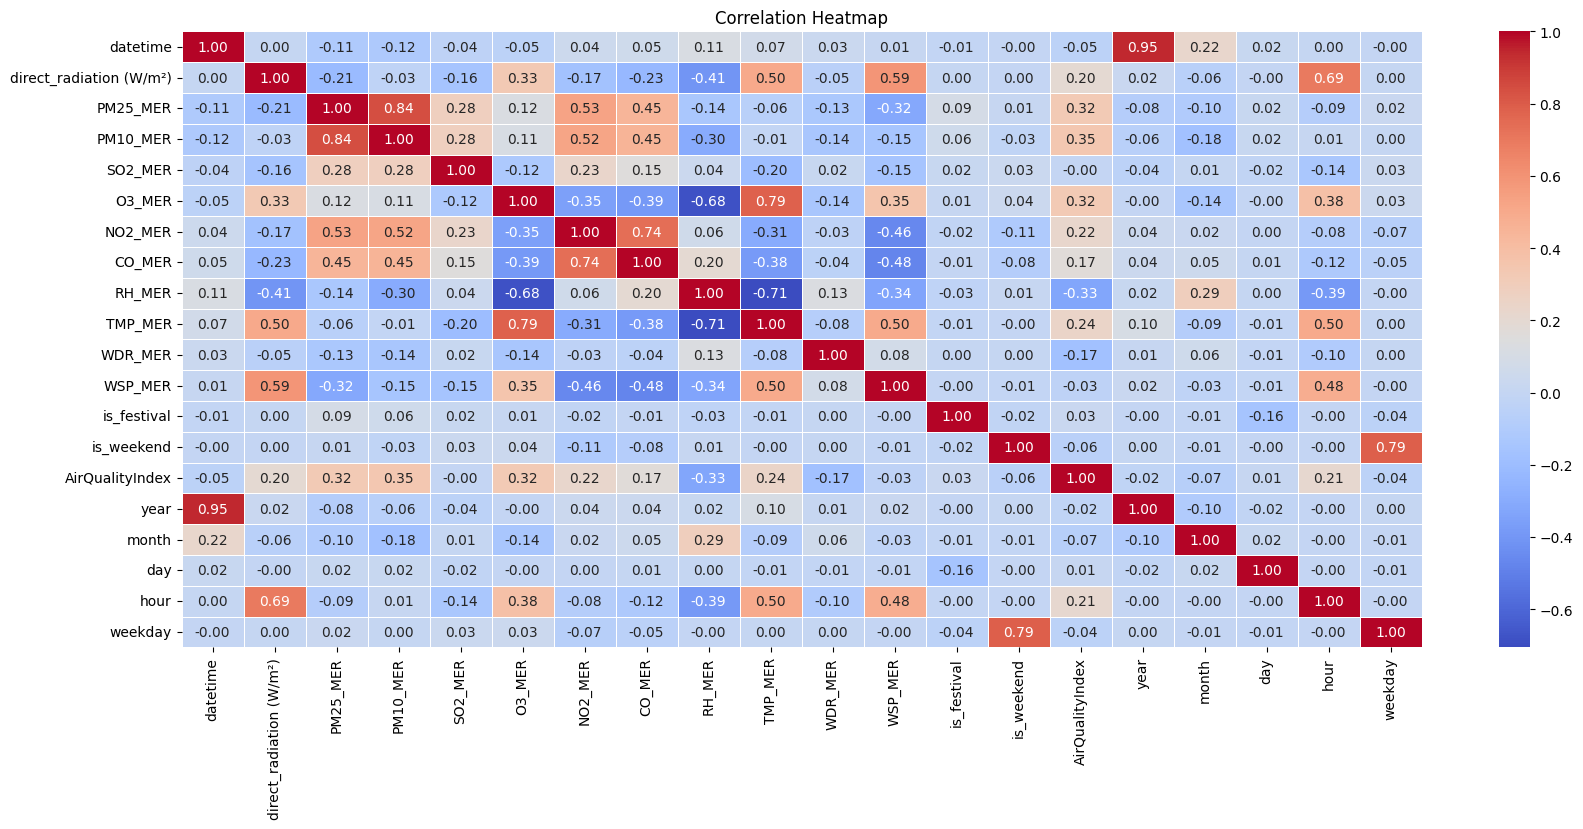

In [ ]:
# --- Correlation Heatmap ///
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**Moving Average for Pollutants**

In [ ]:
# Create a new DataFrame for results
dfWMA = df[['datetime']].copy()  # Copy only datetime column

In [ ]:
# PM 10 Weighted Moving Average
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort data by timestamp
df = df.sort_values('datetime')

# Define weights for the 12-hour period
weights = np.arange(1, 13)  # Weights from 1 to 12

# Function to calculate WMA
def weighted_moving_average(values, weights):
    return np.sum(values * weights) / np.sum(weights)

# Apply WMA for a 12-hour rolling window
dfWMA['WMA_PM10'] = (
    df['PM10_MER']
    .rolling(window=12)  # 12-hour window
    .apply(lambda x: weighted_moving_average(x, weights), raw=True)
)

"""The first 11 rows of the WMA column will be
NaN because the rolling window requires at least 12 data points to compute the WMA."""

# Define PM10 categories
conditions = [
    (dfWMA['WMA_PM10'] < 45),
    (dfWMA['WMA_PM10'] >= 45) & (dfWMA['WMA_PM10'] <= 60),
    (dfWMA['WMA_PM10'] > 60) & (dfWMA['WMA_PM10'] <= 132),
    (dfWMA['WMA_PM10'] > 132) & (dfWMA['WMA_PM10'] <= 213),
    (dfWMA['WMA_PM10'] > 213)
]
air_quality = ['Good', 'Acceptable', 'Bad', 'Very Bad', 'Extremely Bad']
risk_level = ['Low', 'Moderate', 'High', 'Very High', 'Extremely High']

# Add Air Quality and Associated Risk Level columns
dfWMA['Air Quality PM10'] = np.select(conditions, air_quality, default=np.nan)
dfWMA['Associated Risk Level PM10'] = np.select(conditions, risk_level, default=np.nan)

In [ ]:
# PM 2.5 Weighted Moving Average
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort data by timestamp
df = df.sort_values('datetime')

# Define weights for the 12-hour period
weights = np.arange(1, 13)  # Weights from 1 to 12

# Function to calculate WMA
def weighted_moving_average(values, weights):
    return np.sum(values * weights) / np.sum(weights)

# Apply WMA for a 12-hour rolling window
dfWMA['WMA_PM2.5'] = (
    df['PM25_MER']
    .rolling(window=12)  # 12-hour window
    .apply(lambda x: weighted_moving_average(x, weights), raw=True)
)

# Define PM2.5 categories
conditions = [
    (dfWMA['WMA_PM2.5'] < 15),
    (dfWMA['WMA_PM2.5'] >= 15) & (dfWMA['WMA_PM2.5'] <= 33),
    (dfWMA['WMA_PM2.5'] > 33) & (dfWMA['WMA_PM2.5'] <= 79),
    (dfWMA['WMA_PM2.5'] > 79) & (dfWMA['WMA_PM2.5'] <= 130),
    (dfWMA['WMA_PM2.5'] > 130)
]
air_quality = ['Good', 'Acceptable', 'Bad', 'Very Bad', 'Extremely Bad']
risk_level = ['Low', 'Moderate', 'High', 'Very High', 'Extremely High']

# Add Air Quality and Associated Risk Level columns
dfWMA['Air Quality PM2.5'] = np.select(conditions, air_quality, default=np.nan)
dfWMA['Associated Risk Level PM2.5'] = np.select(conditions, risk_level, default=np.nan)

In [ ]:
# CO Weighted Moving Average
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort data by timestamp
df = df.sort_values('datetime')

# Define weights for the 8-hour period
weights = np.arange(1, 9)  # Weights from 1 to 8

# Function to calculate WMA
def weighted_moving_average(values, weights):
    return np.sum(values * weights) / np.sum(weights)

# Apply WMA for a 8-hour rolling window
dfWMA['WMA_CO'] = (
    df['CO_MER']
    .rolling(window=8)  # 8-hour window
    .apply(lambda x: weighted_moving_average(x, weights), raw=True)
)

"""Edge Case Handling: The first 7 rows of the WMA column will be
NaN because the rolling window requires at least 8 data points to compute the WMA."""

# Define PM10 categories
conditions = [
    (dfWMA['WMA_CO'] < 45),
    (dfWMA['WMA_CO'] >= 45) & (dfWMA['WMA_CO'] <= 60),
    (dfWMA['WMA_CO'] > 60) & (dfWMA['WMA_CO'] <= 132),
    (dfWMA['WMA_CO'] > 132) & (dfWMA['WMA_CO'] <= 213),
    (dfWMA['WMA_CO'] > 213)
]
air_quality = ['Good', 'Acceptable', 'Bad', 'Very Bad', 'Extremely Bad']
risk_level = ['Low', 'Moderate', 'High', 'Very High', 'Extremely High']

# Add Air Quality and Associated Risk Level columns
dfWMA['Air Quality CO'] = np.select(conditions, air_quality, default=np.nan)
dfWMA['Associated Risk Level CO'] = np.select(conditions, risk_level, default=np.nan)

In [ ]:
"""The first 11 rows of the WMA PM10 and PM2.5 and first 7 rows of CO columns will be
NaN because the rolling window requires at least 12 and 8 data points respectively to compute the WMA."""
dfWMA.head(15)

,datetime,WMA_PM10,Air Quality PM10,Associated Risk Level PM10,WMA_PM2.5,Air Quality PM2.5,Associated Risk Level PM2.5,WMA_CO,Air Quality CO,Associated Risk Level CO
0,2020-11-25 01:00:00,NaN,nan,nan,NaN,nan,nan,NaN,nan,nan
1,2020-11-25 02:00:00,NaN,nan,nan,NaN,nan,nan,NaN,nan,nan
2,2020-11-25 03:00:00,NaN,nan,nan,NaN,nan,nan,NaN,nan,nan
3,2020-11-25 04:00:00,NaN,nan,nan,NaN,nan,nan,NaN,nan,nan
4,2020-11-25 05:00:00,NaN,nan,nan,NaN,nan,nan,NaN,nan,nan
5,2020-11-25 06:00:00,NaN,nan,nan,NaN,nan,nan,NaN,nan,nan
6,2020-11-25 07:00:00,NaN,nan,nan,NaN,nan,nan,NaN,nan,nan
7,2020-11-25 08:00:00,NaN,nan,nan,NaN,nan,nan,1.252778,Good,Low
8,2020-11-25 09:00:00,NaN,nan,nan,NaN,nan,nan,1.294444,Good,Low
9,2020-11-25 10:00:00,NaN,nan,nan,NaN,nan,nan,1.258333,Good,Low


**Feature Engineering**

Fourier Transform - slight increase for other models, for GBT it has more impact

In [ ]:
#direct radiation fourier transform
# Step 1: Handle missing or non-numerical values (if necessary)
df['direct_radiation (W/m²)'] = pd.to_numeric(df['direct_radiation (W/m²)'], errors='coerce')  # Convert to numeric
df['direct_radiation (W/m²)'] = df['direct_radiation (W/m²)'].fillna(0)  # Replace NaNs with 0 (or interpolate)

# Step 2: Apply FFT to the column
fft_values = fft(df['direct_radiation (W/m²)'])

# Step 3: Create a DataFrame with the results (optional)
df_fft = pd.DataFrame({
    'frequency': np.fft.fftfreq(len(df)),  # Frequency components
    'amplitude': np.abs(fft_values)       # Magnitude of the FFT
})

# Display the results
print(df_fft)

df = pd.concat([df, df_fft], axis=1)  # Concatenate along columns

       frequency     amplitude
0       0.000000  5.312042e+06
1       0.000037  1.400766e+05
2       0.000075  9.176956e+04
3       0.000112  4.409242e+05
4       0.000149  9.662148e+04
...          ...           ...
26783  -0.000187  1.883669e+05
26784  -0.000149  9.662148e+04
26785  -0.000112  4.409242e+05
26786  -0.000075  9.176956e+04
26787  -0.000037  1.400766e+05

[26788 rows x 2 columns]


**Model Training**



In [ ]:
def split_data(df, target_column):
    # Drop the 'datetime' column here
    X = df.drop(columns=[target_column, 'datetime'])
    y = df[target_column]
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = split_data(df, target_column='AirQualityIndex')

In [ ]:
# --- XGBoost Regression (from original notebook)
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Results (Basic):")
print(f"  Mean Squared Error: {mse_xgb:.4f}")
print(f"  Mean Absolute Error: {mae_xgb:.4f}")
print(f"  Root Mean Squared Error: {rmse_xgb:.4f}")
print(f"  R-squared: {r2_xgb:.4f}")

XGBoost Results (Basic):
  Mean Squared Error: 0.6983
  Mean Absolute Error: 0.6576
  Root Mean Squared Error: 0.8357
  R-squared: 0.6222


**Classification**
- I think this is a classification task rather than regression because AirQualityIndex might be an ordinal categorical variable, as such I used accuracy as a metric.

Random Forest

In [ ]:
# Combine features with target labels
train_ds_pd = pd.concat([X_train, y_train], axis=1)
valid_ds_pd = pd.concat([X_test, y_test], axis=1)

label = 'AirQualityIndex'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.CLASSIFICATION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.CLASSIFICATION)

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
rf.compile(metrics=["accuracy", "mse"])

Use /tmp/tmpxwd_euv8 as temporary training directory


In [ ]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.807563. Found 21430 examples.
Training model...
Model trained in 0:00:40.524493
Compiling model...
Model compiled.


In [ ]:
evaluation = rf.evaluate(train_ds)
print('Test Accuracy (Classification):', evaluation[1])
print('Test MSE (Classification):', evaluation[2])

22/22 [==============================] - 5s 197ms/step - loss: 0.0000e+00 - accuracy: 0.9301 - mse: 10.8639
Test Accuracy (Classification): 0.930051326751709
Test MSE (Classification): 10.863879203796387


GBT

In [ ]:
gbt = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
gbt.compile(metrics=["accuracy", "mse"])

Use /tmp/tmp_yo3d7l2 as temporary training directory


In [ ]:
gbt.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.715708. Found 21430 examples.
Training model...
Model trained in 0:01:05.672691
Compiling model...
Model compiled.


In [ ]:
evaluation = gbt.evaluate(train_ds)
print('Test Accuracy (Classification):', evaluation[1])
print('Test MSE (Classification):', evaluation[2])

22/22 [==============================] - 3s 133ms/step - loss: 0.0000e+00 - accuracy: 0.8827 - mse: 10.8750
Test Accuracy (Classification): 0.882734477519989
Test MSE (Classification): 10.874979019165039


GBT Fourier Transform, from 79% - 88%

XGBoost Classification

In [ ]:
# Adjust class labels to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialize XGBoost model
xgBooster = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class classification
    num_class=5,                 # Number of classes
    use_label_encoder=False,     # To avoid warnings about label encoding
    eval_metric='mlogloss'       # Evaluation metric
)

# Train the model
xgBooster.fit(X_train, y_train_adjusted)

# Predict probabilities for each class (since we are using 'multi:softprob')
y_pred_prob = xgBooster.predict_proba(X_test)

# Convert probabilities to class labels by choosing the class with the highest probability
y_pred = np.argmax(y_pred_prob, axis=1)

# Adjust predicted labels to match original class labeling
y_pred_original = y_pred + 1

# Calculate accuracy
accuracy = accuracy_score(y_test_adjusted, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test_adjusted, y_pred)

print('Test Accuracy (Classification):', accuracy)
print('Test MSE (Classification):', mse)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:58:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy (Classification): 0.5586039567002613
Test MSE (Classification): 1.082306830907055


CART Model

In [ ]:
cm = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
cm.compile(metrics=["accuracy", "mse"])

Use /tmp/tmp_m91_fzq as temporary training directory


In [ ]:
cm.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.796516. Found 21430 examples.
Training model...
Model trained in 0:00:00.477553
Compiling model...
Model compiled.


In [ ]:
evaluation = cm.evaluate(train_ds)
print('Test Accuracy (Classification):', evaluation[1])
print('Test MSE (Classification):', evaluation[2])

22/22 [==============================] - 1s 19ms/step - loss: 0.0000e+00 - accuracy: 0.5532 - mse: 10.8589
Test Accuracy (Classification): 0.5531964302062988
Test MSE (Classification): 10.858945846557617
